In [65]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class Minesweeper:
    def __init__(self, rows, cols, num_mines):
        """
        Initialize the Minesweeper game.
        """
        self.rows = rows
        self.cols = cols
        self.num_mines = num_mines
        self.board = np.zeros((rows, cols), dtype=int)
        self.internal_state = np.full((rows, cols), None)
        self.revealed = set()
        self.mines = set()
        self.last_move = None  # Initialize last_move
        self.place_mines()
        self.calculate_hints()
        self.initialize_internal_state()

    def place_mines(self):
        """
        Randomly place mines on the board.
        Mines are represented by -1.
        """
        all_positions = [(r, c) for r in range(self.rows) for c in range(self.cols)]
        self.mines = set(random.sample(all_positions, self.num_mines))
        for (r, c) in self.mines:
            self.board[r][c] = -1

    def calculate_hints(self):
        """
        For each cell that is not a mine, calculate the number of neighboring mines.
        """
        for r in range(self.rows):
            for c in range(self.cols):
                if self.board[r][c] == -1:
                    continue
                count = 0
                for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        nr, nc = r + dr, c + dc
                        if dr == 0 and dc == 0:
                            continue
                        if 0 <= nr < self.rows and 0 <= nc < self.cols:
                            if self.board[nr][nc] == -1:
                                count += 1
                self.board[r][c] = count

    def initialize_internal_state(self):
        """
        Initialize the internal state grid.
        None represents unrevealed cells.
        """
        self.internal_state = np.full((self.rows, self.cols), None)
        self.revealed = set()
        self.last_move = None  # Reset last_move

    def reveal_square(self, r, c):
        """
        Reveal the cell at (r, c).
        Returns False if a mine is revealed, True otherwise.
        """
        if (r, c) in self.revealed:
            return True  # Already revealed

        self.last_move = (r, c)  # Record the last move

        if self.board[r][c] == -1:
            self.internal_state[r][c] = -1  # Reveal mine
            self.revealed.add((r, c))
            return False  # Mine revealed

        # Initialize a queue for iterative BFS
        queue = [(r, c)]

        while queue:
            current_r, current_c = queue.pop(0)
            
            if (current_r, current_c) in self.revealed:
                continue  # Skip already revealed cells

            # Reveal the current cell
            self.internal_state[current_r][current_c] = self.board[current_r][current_c]
            self.revealed.add((current_r, current_c))

            # If the cell has zero neighboring mines, add its neighbors to the queue
            if self.board[current_r][current_c] == 0:
                for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        nr, nc = current_r + dr, current_c + dc
                        if dr == 0 and dc == 0:
                            continue  # Skip the current cell itself
                        if 0 <= nr < self.rows and 0 <= nc < self.cols:
                            if (nr, nc) not in self.revealed and (nr, nc) not in queue:
                                queue.append((nr, nc))

        return True


    def display_board(self):
        """
        Display the actual board (for debugging purposes).
        """
        display = self.board.copy()
        display[display == -1] = -1
        for r in range(self.rows):
            row = ''
            for c in range(self.cols):
                if display[r][c] == -1:
                    row += ' * '
                else:
                    row += f' {display[r][c]} '
            print(row)
        print()

    def plot_board(self):
        """
        Plot the current state of the board using Seaborn's heatmap.
        - Unrevealed cells are shown in a specific color (e.g., gray).
        - Revealed numbers are colored based on their value.
        - Mines are highlighted if revealed.
        - The last revealed square is highlighted with a red edge.
        """
        # Create a numerical representation for plotting
        plot_data = np.full((self.rows, self.cols), -2)  # -2 for unrevealed

        for r in range(self.rows):
            for c in range(self.cols):
                if (r, c) in self.revealed:
                    plot_data[r][c] = self.internal_state[r][c]
                else:
                    plot_data[r][c] = -2  # Unrevealed

        # Define a custom colormap
        cmap = ListedColormap([
            'lightgray',  # -2 Unrevealed
            'black',      # -1 Mine
            'white',      # 0
            'lightblue',  # 1
            'blue',       # 2
            'darkblue',   # 3
            'purple',     # 4
            'red',        # 5
            'darkred',    # 6
            'orange',     # 7
            'brown',      # 8
            'black'       # 9 (Not used, just in case)
        ])

        # Define the range and norm
        bounds = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        plt.figure(figsize=(10, 10))
        ax = sns.heatmap(plot_data, cmap=cmap, norm=norm, linewidths=0.5, linecolor='black', cbar=False)

        # Add annotations
        for r in range(self.rows):
            for c in range(self.cols):
                value = plot_data[r][c]
                if value == -2:
                    plt.text(c + 0.5, r + 0.5, '?', 
                            horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=12, color='black')
                elif value > 0:
                    plt.text(c + 0.5, r + 0.5, str(value), 
                            horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=12, color='white')
                elif value == 0:
                    plt.text(c + 0.5, r + 0.5, '0', 
                            horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=12)

        # Highlight the last move
        if self.last_move and self.last_move in self.revealed:
            r, c = self.last_move
            # Draw a red rectangle around the last move
            ax.add_patch(plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='red', linewidth=3))

        plt.title('Minesweeper Board')
        plt.axis('off')
        plt.gca().invert_yaxis()
        

    def plot_mines(self):
        """
        Plot the positions of all mines on the board using a heatmap.
        Mines are highlighted in red, and other cells are shown in white.
        """
        # Create a matrix where mines are 1 and other cells are 0
        mine_matrix = np.zeros((self.rows, self.cols))
        for (r, c) in self.mines:
            mine_matrix[r][c] = 1

        # Define a custom colormap: white for non-mines, red for mines
        cmap = ListedColormap(['grey', 'red'])
        plt.figure(figsize=(10, 10))
        # Plot the heatmap
        sns.heatmap(mine_matrix, cmap=cmap, linewidths=0.5, linecolor='black', cbar=False)


        plt.title('Mine Positions')
        plt.axis('off')
        plt.gca().invert_yaxis()
        


In [49]:
class Agent:
    def __init__(self):
        """
        Base Agent class. To be extended by specific agent implementations.
        """
        pass

    def choose_move(self, game):
        """
        Decide the next move based on the current game state.

        Parameters:
        - game (Minesweeper): The current Minesweeper game instance.

        Returns:
        - tuple: (row, column) of the next move.
        """
        raise NotImplementedError("This method should be implemented by subclasses.")

class RandomAgent(Agent):
    def __init__(self):
        """
        Agent that chooses moves randomly from unrevealed cells.
        """
        super().__init__()

    def choose_move(self, game):
        """
        Choose a random unrevealed cell to reveal.

        Parameters:
        - game (Minesweeper): The current Minesweeper game instance.

        Returns:
        - tuple: (row, column) of the next move.
        """
        unrevealed = [(r, c) for r in range(game.rows) 
                              for c in range(game.cols) 
                              if (r, c) not in game.revealed]
        if not unrevealed:
            return None  # No moves left
        return random.choice(unrevealed)
    
    
class LogicAgent(Agent):
    def __init__(self):
        """
        Deterministic Rule-Based Agent that uses basic Minesweeper logic to choose moves.
        """
        super().__init__()
        self.suspected_mines = set()
        self.safe_moves = set()

    def choose_move(self, game):
        """
        Choose the next move based on Minesweeper logic.

        Parameters:
        - game (Minesweeper): The current Minesweeper game instance.

        Returns:
        - tuple: (row, column) of the next move, or None if no move can be determined.
        """
        self.update_knowledge(game)

        # If there are known safe moves, prioritize them
        if self.safe_moves:
            move = self.safe_moves.pop()
            return move

        # If no safe moves, pick a random move excluding suspected mines
        move = self.pick_random_move(game)
        return move

    def update_knowledge(self, game):
        """
        Update the agent's knowledge base by applying inference rules.

        Parameters:
        - game (Minesweeper): The current Minesweeper game instance.
        """
        changed = True
        while changed:
            changed = False
            for (r, c) in list(game.revealed):
                clue = game.internal_state[r][c]
                if clue is None or clue == -1:
                    continue

                # Get neighbors
                neighbors = self.get_neighbors(game, r, c)
                unrevealed = [cell for cell in neighbors if cell not in game.revealed and cell not in self.suspected_mines]

                # Count how many neighboring cells are already suspected mines
                suspected = [cell for cell in neighbors if cell in self.suspected_mines]

                # Rule 1: If number on cell equals number of suspected mines, remaining neighbors are safe
                if clue == len(suspected):
                    for cell in unrevealed:
                        if cell not in self.safe_moves:
                            self.safe_moves.add(cell)
                            changed = True

                # Rule 2: If number on cell equals suspected mines plus unrevealed neighbors, all unrevealed neighbors are mines
                elif clue == len(suspected) + len(unrevealed):
                    for cell in unrevealed:
                        if cell not in self.suspected_mines:
                            self.suspected_mines.add(cell)
                            changed = True

    def get_neighbors(self, game, r, c):
        """
        Get all valid neighboring cells around (r, c).

        Parameters:
        - game (Minesweeper): The current Minesweeper game instance.
        - r (int): Row index.
        - c (int): Column index.

        Returns:
        - list of tuples: Neighboring cell coordinates.
        """
        neighbors = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                nr, nc = r + dr, c + dc
                if dr == 0 and dc == 0:
                    continue
                if 0 <= nr < game.rows and 0 <= nc < game.cols:
                    neighbors.append((nr, nc))
        return neighbors

    def pick_random_move(self, game):
        """
        Pick a random move from the remaining unrevealed cells excluding suspected mines.

        Parameters:
        - game (Minesweeper): The current Minesweeper game instance.

        Returns:
        - tuple: (row, column) of the next move, or None if no move can be determined.
        """
        unrevealed = [(r, c) for r in range(game.rows) 
                              for c in range(game.cols) 
                              if (r, c) not in game.revealed and (r, c) not in self.suspected_mines]
        if not unrevealed:
            return None
        return random.choice(unrevealed)

In [44]:
import os
class Simulation:
    def __init__(self, rows, cols, num_mines, agent, save_dir='simulation_images'):
        """
        Initialize the simulation.

        Parameters:
        - rows (int): Number of rows in the board.
        - cols (int): Number of columns in the board.
        - num_mines (int): Number of mines on the board.
        - agent (Agent): The agent that will play the game.
        - save_dir (str): Directory to save the heatmap images.
        """
        self.game = Minesweeper(rows, cols, num_mines)
        self.agent = agent
        self.save_dir = save_dir
        self.move_count = 0
        self.create_save_directory()

    def create_save_directory(self):
        """
        Create the directory to save images if it doesn't exist.
        """
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        else:
            # Clear existing images
            for filename in os.listdir(self.save_dir):
                file_path = os.path.join(self.save_dir, filename)
                if os.path.isfile(file_path):
                    os.unlink(file_path)

    def run(self):
        """
        Run the simulation until the game is over (win or lose).

        Returns:
        - bool: True if the agent won, False if it hit a mine.
        """
        self.save_mines_image()
        while True:
            # Save current board state
            self.save_board_image()

            # Check for win condition
            if self.check_win():
                print("Agent has successfully cleared the board!")
                return True

            # Agent chooses next move
            move = self.agent.choose_move(self.game)
            if move is None:
                print("No more moves left. Game over.")
                return False

            r, c = move
            print(f"Move {self.move_count + 1}: Revealing cell ({r}, {c})")
            safe = self.game.reveal_square(r, c)
            self.move_count += 1

            if not safe:
                # Save final board state with mine revealed
                self.save_board_image()
                print(f"Agent hit a mine at ({r}, {c}). Game over.")
                return False

    def check_win(self):
        """
        Check if all non-mine cells have been revealed.

        Returns:
        - bool: True if the agent has won, False otherwise.
        """
        total_cells = self.game.rows * self.game.cols
        if len(self.game.revealed) == total_cells - self.game.num_mines:
            return True
        return False
    
    def save_mines_image(self):
        """
        Save the positions of all mines on the board as an image.
        """
        filename = os.path.join(self.save_dir, "mines.png")
        plt.figure(figsize=(10, 8))
        self.game.plot_mines()
        plt.savefig(filename)
        plt.close()

    def save_board_image(self):
        """
        Save the current state of the board as an image.
        """
        filename = os.path.join(self.save_dir, f"move_{self.move_count:04d}.png")
        plt.figure(figsize=(10, 8))       # Create a new figure
        self.game.plot_board()            # Plot on the current figure
        plt.savefig(filename)             # Save the current figure
        plt.close()                       # Close the figure to free memory



In [14]:
rows, cols, num_mines = 10, 10, 15

# Initialize game and AI agent
game = Minesweeper(rows, cols, num_mines)
game.display_board()
# game.plot_board()

 1  1  1  *  1  0  1  1  1  0 
 *  1  1  2  2  1  1  *  1  0 
 2  2  1  3  *  3  2  1  1  0 
 *  1  1  *  *  *  1  1  1  1 
 1  1  1  2  3  2  1  1  *  2 
 0  0  0  0  0  0  0  2  3  * 
 1  1  1  1  1  0  0  1  *  2 
 *  2  1  *  1  0  0  1  1  1 
 *  2  1  1  1  0  0  1  1  1 
 1  1  0  0  0  0  0  1  *  1 



In [66]:
if __name__ == "__main__":
    # Define game parameters
    rows = 10
    cols = 10
    num_mines = 15

    # Initialize agent and simulation
    agent = LogicAgent()
    simulation = Simulation(rows, cols, num_mines, agent, save_dir='simulation_images')

    # Run the simulation
    result = simulation.run()

    if result:
        print("Agent won the game!")
    else:
        print("Agent lost the game.")


Move 1: Revealing cell (4, 4)
Move 2: Revealing cell (2, 2)
Move 3: Revealing cell (4, 5)
Move 4: Revealing cell (2, 7)
Move 5: Revealing cell (5, 8)
Move 6: Revealing cell (4, 9)
Move 7: Revealing cell (3, 7)
Move 8: Revealing cell (1, 9)
Move 9: Revealing cell (6, 8)
Move 10: Revealing cell (0, 9)
Move 11: Revealing cell (5, 1)
Move 12: Revealing cell (2, 9)
Move 13: Revealing cell (6, 7)
Move 14: Revealing cell (2, 6)
Move 15: Revealing cell (5, 9)
Move 16: Revealing cell (6, 9)
Move 17: Revealing cell (4, 7)
Move 18: Revealing cell (3, 5)


/var/folders/bn/llk1pmgn40d3pd2v_zdcks9h0000gn/T/ipykernel_33543/3347290973.py:158: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))
/var/folders/bn/llk1pmgn40d3pd2v_zdcks9h0000gn/T/ipykernel_33543/2158832625.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))       # Create a new figure


Move 19: Revealing cell (5, 2)
Move 20: Revealing cell (6, 2)
Move 21: Revealing cell (3, 0)
Move 22: Revealing cell (5, 0)
Move 23: Revealing cell (6, 1)
Move 24: Revealing cell (6, 4)
Move 25: Revealing cell (7, 3)
Move 26: Revealing cell (6, 0)
Move 27: Revealing cell (7, 5)
Move 28: Revealing cell (7, 4)
Move 29: Revealing cell (8, 4)
Move 30: Revealing cell (6, 5)
Move 31: Revealing cell (2, 0)
Move 32: Revealing cell (8, 3)
Move 33: Revealing cell (7, 6)
Move 34: Revealing cell (8, 6)
Move 35: Revealing cell (8, 5)
Move 36: Revealing cell (7, 7)
Move 37: Revealing cell (0, 0)
Move 38: Revealing cell (8, 7)
Move 39: Revealing cell (8, 0)
Move 40: Revealing cell (7, 9)
Move 41: Revealing cell (8, 9)
Move 42: Revealing cell (9, 1)
Move 43: Revealing cell (8, 8)
Move 44: Revealing cell (9, 0)
Move 45: Revealing cell (9, 2)
Move 46: Revealing cell (9, 3)
Move 47: Revealing cell (9, 6)
Move 48: Revealing cell (9, 5)
Move 49: Revealing cell (9, 9)
Agent has successfully cleared the boar

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [15]:
game.reveal_square(0, 0)

True

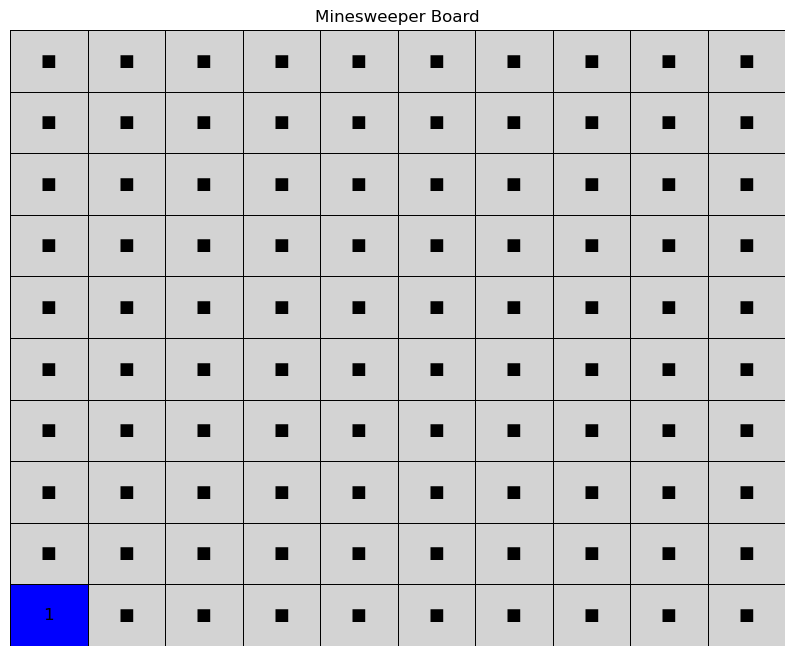

In [16]:
game.plot_board()